In [1]:
import numpy as np
from dataclasses import dataclass
from abc import ABC, abstractmethod
from typing import Optional, List
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
WORLD_SHAPE = (200, 200)
STEP = 20
meeting_point = np.array([10, 10])


XX, YY = np.meshgrid(range(STEP, WORLD_SHAPE[0], STEP), range(STEP, WORLD_SHAPE[1], STEP))
XY = np.dstack([XX, YY])
XY.shape

(9, 9, 2)

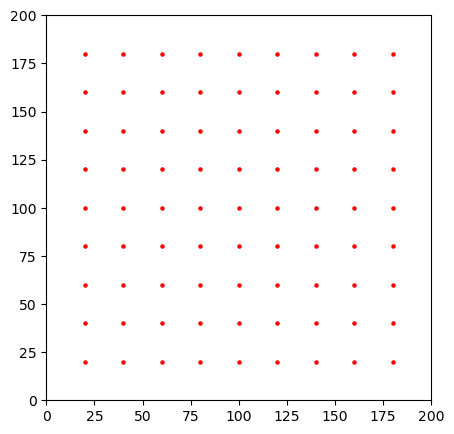

In [3]:
fig = plt.figure(figsize=(5, 5), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

def scatter_tasks(ax, XY):
    ax.scatter(XY[:, :, 0], XY[:, :, 1], s=5, c='red')
    ax.set_xlim(0, WORLD_SHAPE[0])
    ax.set_ylim(0, WORLD_SHAPE[1])

scatter_tasks(ax, XY)

In [4]:
@dataclass
class Task:
    p: np.ndarray
    reward: int = 10

In [5]:
@dataclass
class IndividualParams:
    number_of_agents: int = 2
    number_of_tasks: int = XX.shape[0] * XX.shape[1]
    mutation_prob: float = 0.04

class IndividualInterface(ABC):
    @staticmethod
    @abstractmethod
    def initialize_path():
        pass

class Individual(IndividualInterface):
    """
    Estrutura do array `paths`: np.ndarray
    - shape: (number_of_agents, number_of_tasks, 2)
    - O primeiro eixo representa os diferentes agentes.
    - O segundo eixo representa as recompensas no ambiente.
    - O terceiro eixo tem dois elementos: um que indica se a recompensa está no caminho do agente e outro que indica a ordem do caminho.

    Exemplo:
        paths = np.array([
        # Agente 1
        [[1, 0.5],  # Recompensa 1: Visita (1), ordem 0.5
        [0, 0.0],  # Recompensa 2: Não visita (0)
        [1, 0.3]], # Recompensa 3: Visita (1), ordem 0.3
        
        # Agente 2
        [[0, 0.0],  # Recompensa 1: Não visita (0)
        [1, 0.7],  # Recompensa 2: Visita (1), ordem 0.7
        [1, 0.2]]  # Recompensa 3: Visita (1), ordem 0.2
        ])
    """
    def __init__(self, params: IndividualParams, genes: Optional[np.ndarray] = None):
        if genes is None:
            self.paths = np.array([
                    self.initialize_path(params.number_of_tasks)
                    for _ in range(params.number_of_agents)
                ])
        else:
            self.paths = genes
        self.fitness = 0

    @staticmethod
    def initialize_path(number_of_tasks: int) -> np.ndarray:
        tasks_in_path = np.random.choice([0, 1], number_of_tasks)
        path_order = np.random.random(number_of_tasks)

        return np.vstack([tasks_in_path, path_order]).T

In [6]:
@dataclass
class PopulationParams:
    population_size: int = 10
    tournament_size: int = 5
    crossover_prob: float = 0.8
    mutation_prob: float = 0.5


class PopulationInterface(ABC):
    @abstractmethod
    def select_parents(self, method) -> List[Individual]:
        pass
    @abstractmethod
    def crossover(self) -> List[Individual]:
        pass
    @abstractmethod
    def mutate(self, individuals: List[Individual]) -> List[Individual]:
        pass
    @staticmethod
    @abstractmethod
    def fitness(individual) -> float:
        pass


@dataclass(frozen=True)
class SelectionMethods:
    TOURNAMENT: str = 'tournament'
    ROULETTE: str = 'roulette'


class Population(PopulationInterface):
    def __init__(self, ind_params: IndividualParams, pop_params: PopulationParams, 
                 ind_genes: Optional[List[np.ndarray]]):
        if ind_genes is None:
            self.individuals = [Individual(ind_params) for _ in range(pop_params.population_size)]
        else:
            self.individuals = [Individual(ind_params, ind_genes[i]) for i in range(pop_params.population_size)]
        self._params = pop_params
        self._ind_params = ind_params
    

    def select_parents(self, method: Optional[SelectionMethods]='tournament') -> List[Individual]:
        if method == SelectionMethods.ROULETTE:
            select = self.__select_by_roulette
        else:
            select = self.__select_by_tournament

        parent1 = select()
        parent2 = select()
        # Verifica se é a mesma instância de Individual. 
        # Duas instãncias diferentes podem ter os mesmos genes, mas na prática a chance é pequena.
        while parent1 == parent2:
            parent2 = select()
        
        return [parent1, parent2]
    

    def __select_by_roulette(self) -> Individual: # Only works for positive fitness
        total_fitness = sum([individual.fitness for individual in self.individuals])
        probs = [sum(individual.fitness[:i+1])/total_fitness for i, individual in enumerate(self.individuals)]

        r = np.random.random()
        for i, individual in enumerate(self.individuals):
            if r < probs[i]:
                winner = individual
                return winner

        return self.individuals[-1] # This should never happen
    

    def __select_by_tournament(self) -> Individual:
        tournament = np.random.choice(self.individuals, self._params.tournament_size, replace=False)
        winner = max(tournament, key=lambda x: x.fitness) 
        return winner
    

    def crossover(self) -> List[Individual]:
        offspring = []
        for _ in range(self._params.population_size // 2):
            parent1, parent2 = self.select_parents()

            if np.random.random() > self._params.crossover_prob:
                offspring.extend(self.__two_point_crossover(parent1, parent2))
            else:
                offspring.extend([parent1, parent2]) # TODO: check if its necessary to do a copy of the objects.
        return offspring


    def __two_point_crossover(self, parent1: Individual, parent2: Individual) -> Individual:
        lp, up = np.random.randint(0, parent1.paths.shape[1], 2)
        if lp > up:
            lp, up = up, lp

        genes1 = np.concatenate([parent1.paths[:, :lp], parent2.paths[:, lp:up], parent1.paths[:, up:]], axis=1)
        child1 = Individual(params=self._ind_params, genes=genes1)
        genes2 = np.concatenate([parent2.paths[:, :lp], parent1.paths[:, lp:up], parent2.paths[:, up:]], axis=1)
        child2 = Individual(params=self._ind_params, genes=genes2)

        return child1, child2
        

    def mutate(self, individuals: List[Individual]) -> List[Individual]:
        for individual in individuals:
            if np.random.random() < self._params.mutation_prob:
                self.__mutate_individual(individual) 
    
    
    def __mutate_individual(self, individual: Individual) -> None:
        mutation_mask = self.__select_genes(individual)
        self.__apply_mutation(individual, mutation_mask)


    def __select_genes(self, individual: Individual) -> np.ndarray:
        random = np.random.random(individual.paths.shape[0])
        mutation_mask = random < self._params.mutation_prob
        return mutation_mask
    

    def __apply_mutation(self, individual: Individual, mutation_mask: np.ndarray) -> None:
        if np.any(mutation_mask):
            individual.paths[mutation_mask, 0] = np.random.choice([0, 1], size=np.sum(mutation_mask))
            individual.paths[mutation_mask, 1] = np.random.random(size=np.sum(mutation_mask))


    @staticmethod
    def fitness(individual: Individual, tasks: List[Task], budget: float) -> float:
        length = Population.__calculate_path_length(individual.paths, tasks)

        if length > budget:
            individual.fitness = 0
            return individual.fitness
        
        visited = np.sum(individual.paths, axis=0)[:, 0].astype(bool)
        fitness = np.sum([tasks[i].reward for i in np.where(visited)[0]])
        individual.fitness = fitness
        return fitness


    @staticmethod
    def __calculate_path_length(path: np.ndarray, tasks: List[Task]) -> float:
        max_length = 0

        for i in range(path.shape[0]): # For each agent
            visited = path[i, :, 0].astype(bool)
            path_order = np.argsort(path[i, visited, 1])
            length = 0
            for a, b in zip(path_order[:-1], path_order[1:]):
                length += np.linalg.norm(tasks[a].p - tasks[b].p)
            max_length = max(max_length, length)
        return max_length

In [7]:
paths = np.array([
    # Agente 1
    [[1, 0.5],  # Recompensa 1: Visita (1), ordem 0.5
    [0, 0.0],  # Recompensa 2: Não visita (0)
    [1, 0.3]], # Recompensa 3: Visita (1), ordem 0.3

    # Agente 2
    [[0, 0.0],  # Recompensa 1: Não visita (0)
    [1, 0.7],  # Recompensa 2: Visita (1), ordem 0.7
    [1, 0.2]]  # Recompensa 3: Visita (1), ordem 0.2
])

In [8]:
@dataclass
class GeneticAlgorithmParams:
    tasks: List[Task]
    budget: float = 100000000

class GeneticAlgorithm:
    def __init__(self, stop: int, ind_params: IndividualParams, pop_params: PopulationParams, 
                 ga_params: GeneticAlgorithmParams, ind_genes: Optional[List[np.ndarray]] = None):
        self.population = Population(ind_params, pop_params, ind_genes)
        self._params = ga_params
        self._best_individual = self.population.individuals[0]
        self._best_fitness = 0
        self.stop = stop
    
    def run(self):
        for _ in tqdm(range(self.stop), desc='Progress'):
            offspring = self.population.crossover()
            self.population.mutate(offspring)

            fitness_values = np.array([self.population.fitness(individual, self._params.tasks, self._params.budget) 
                                       for individual in offspring])
            best_offspring_idx = np.argmax(fitness_values)
            best_offspring_fitness = fitness_values[best_offspring_idx]

            if best_offspring_fitness > self._best_fitness:
                self._best_fitness = best_offspring_fitness
                self._best_individual = offspring[best_offspring_idx]

            self.population.individuals = offspring

        return self._best_individual

In [9]:
tasks = [Task(p=point) for point in XY[:, ::2].reshape(-1, 2)]

ind_params = IndividualParams(number_of_agents=2, number_of_tasks=len(tasks), mutation_prob=0.04)
pop_params = PopulationParams(population_size=100, tournament_size=20, crossover_prob=0.8, mutation_prob=0.5)
ga_params = GeneticAlgorithmParams(tasks=tasks, budget=1000)

In [10]:
ga = GeneticAlgorithm(stop=1000, ind_params=ind_params, pop_params=pop_params, ga_params=ga_params)
ga.run()

Progress: 100%|██████████| 1000/1000 [00:22<00:00, 44.28it/s]


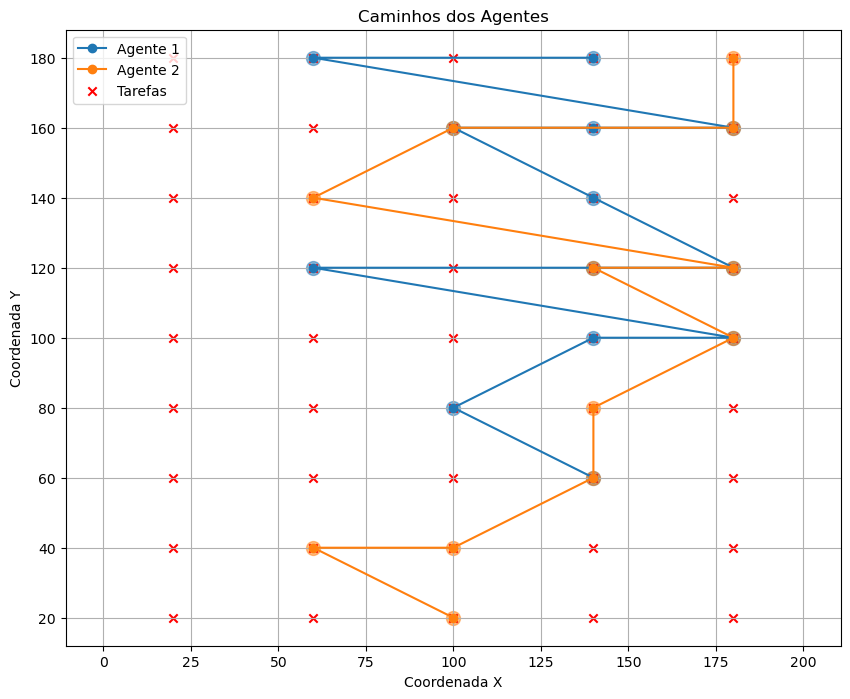

In [11]:
def plot_paths(individual: Individual, tasks: List[Task]):
    plt.figure(figsize=(10, 8))
    
    # Extrai as coordenadas das tarefas
    task_positions = np.array([[task.p[0], task.p[1]] for task in tasks])
    
    # Plota cada agente e seu caminho
    for agent_index in range(individual.paths.shape[0]):
        path = individual.paths[agent_index]  # Caminho do agente
        visited_indices = np.where(path[:, 0] == 1)[0]  # Índices das tarefas visitadas
        
        if visited_indices.size > 0:
            # Pega as posições das tarefas visitadas
            visited_positions = task_positions[visited_indices]
            
            # Plota o caminho
            plt.plot(visited_positions[:, 0], visited_positions[:, 1], marker='o', label=f'Agente {agent_index + 1}')
            plt.scatter(visited_positions[:, 0], visited_positions[:, 1], s=100, alpha=0.5)  # Destaque as tarefas visitadas
            
    # Plota todas as tarefas
    plt.scatter(task_positions[:, 0], task_positions[:, 1], c='red', marker='x', label='Tarefas')
    
    # Configurações do gráfico
    plt.title('Caminhos dos Agentes')
    plt.xlabel('Coordenada X')
    plt.ylabel('Coordenada Y')
    plt.legend()
    plt.grid()
    plt.axis('equal')  # Para manter a proporção
    plt.show()

plot_paths(ga._best_individual, tasks)